In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
from scipy import sparse
from scipy import  integrate
import scipy
import pyshtools
import models
sph_harm_operator=models.sph_harm_operator.sph_harm_operator
import pandas as pd
import os
from matplotlib import  pylab
from scipy.signal import find_peaks

# Calculate the single fibers' trajetory $\mathbf{p}(t)$
Two steps:
1. Calculate the orientation distribution function $\psi(t)$. And plot it in 3D.  
2. Culculate the trajetory of single fiber $\mathbf{p}(t)$. And plot it in 3D.  
  
### step 1: calculate $\psi(t)$

CI-> 0.01


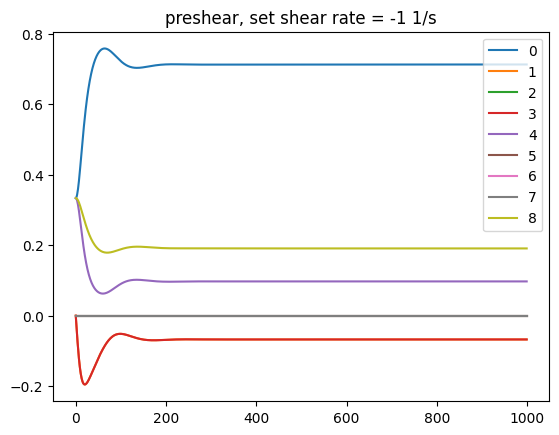

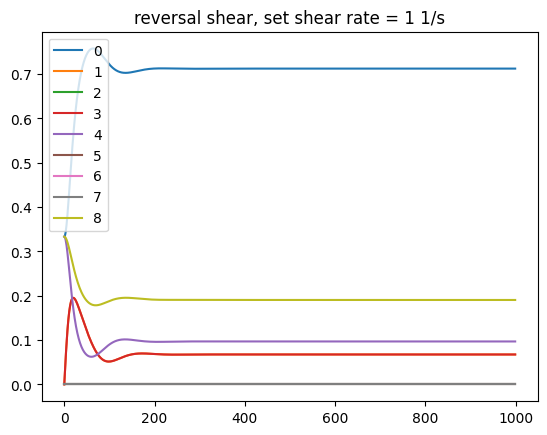

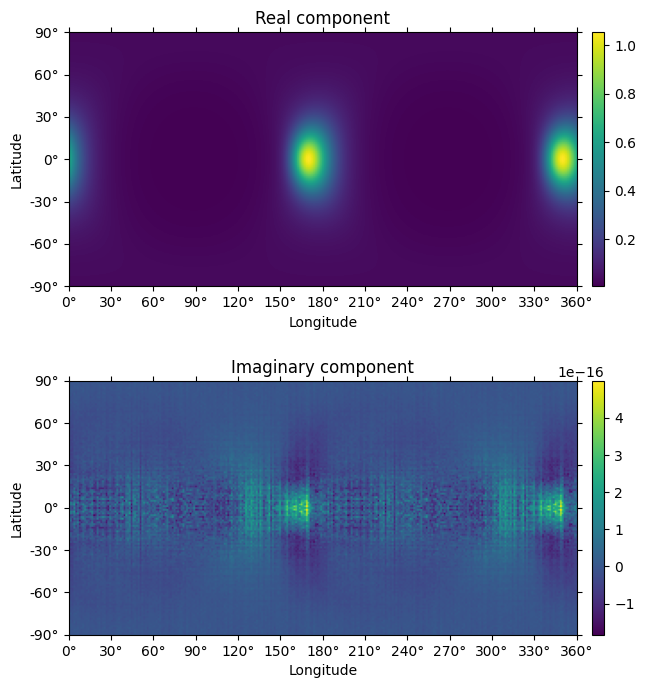

In [2]:
#set the parameters
degree=70
rho=11.8
wt_concentration=0.3
vol_concentration=wt_concentration/2.7/(1-wt_concentration+wt_concentration/2.7)
#CI=0.03*(1-np.exp(-0.224*rho*vol_concentration))
CI=0.01
print('CI->',CI)
k=1
CM=0
confined_alpha=0.5
confined_epsilon=0.25
time_span=np.linspace(0,100,num=1000)
###########################################
#set the shear rate as -1 1/s, which mens the preshear
###########################################
a0=models.ODF_Sph_Harm_Confined(CI=CI,CM=CM,rho=rho,k=k,confined_epsilon=confined_epsilon, \
                                confined_alpha=confined_alpha, \
                                shear_rate=-1,degree=degree,t_span=time_span)
#calculate the ψ(t), which is stored in res2
res2=a0.run_matrix_type()
df_preshear=pd.DataFrame(res2['A2'])
df_preshear.plot(title='preshear, set shear rate = -1 1/s')
##############################################
#set the shear rate as 1 1/s, which mens the reversal shear
##############################################
init_sphharm_co=res2['sphharm_co'][-1,:,:]
a1=models.ODF_Sph_Harm_Confined(CI=CI,CM=CM,rho=rho,k=k,confined_epsilon=confined_epsilon,\
                                confined_alpha=confined_alpha,shear_rate=1,degree=degree, \
                                t_span=time_span,init_sphharm_co=init_sphharm_co)
#calculate the ψ(t), which is stored in res2
res2=a1.run_matrix_type()
df_preshear=pd.DataFrame(res2['A2'])
df_preshear.plot(title='reversal shear, set shear rate = 1 1/s')

#2D orientation distribution 𝜓(𝜽,ϕ)
a1.to_clm(res2['sphharm_co'][-1,:,:]).expand().plot(colorbar="right")
data=np.real(a1.to_clm(res2['sphharm_co'][-1,:,:]).expand().data)
pylab.plot(data[50,:])

- Plot $\psi(\mathbf{p})$ in 3D

(-0.76, 0.76)

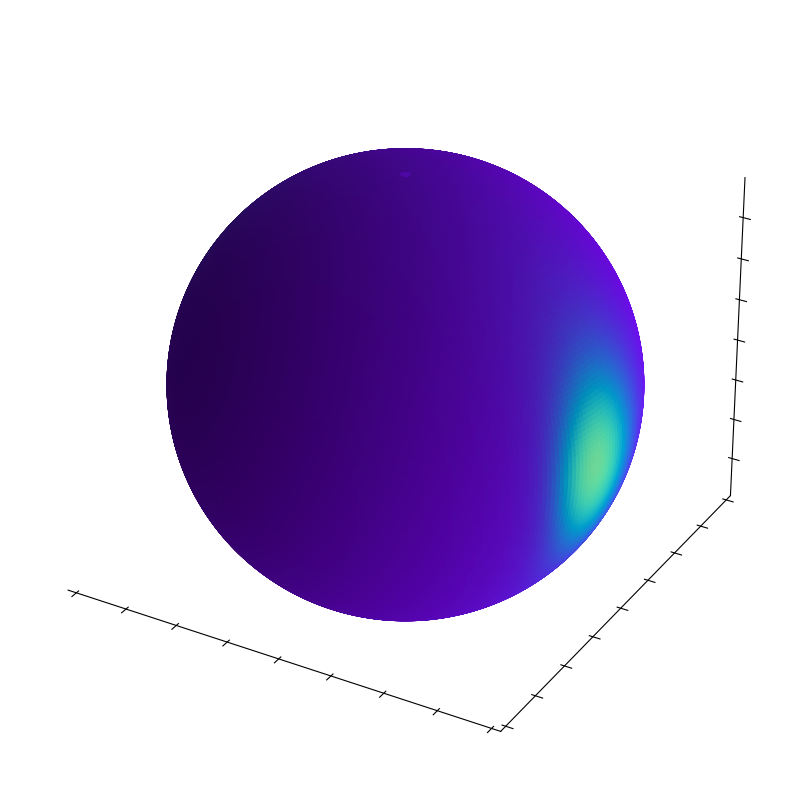

In [3]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
#calculate the Ψ grid by spherical harmonic coefficient
sph_harm_co=res2['sphharm_co'][-1,:,:]
psi_clm=a1.to_clm(sph_harm_co)
psi_grid=psi_clm.expand()
#generate the theta mesh and the phi mesh
theta_span=-psi_grid.lats()/180*np.pi+np.pi/2
phi_span=psi_grid.lons()/180*np.pi-np.pi
theta_mesh,phi_mesh=np.meshgrid(theta_span,phi_span,indexing='ij')

#The Cartesian coordinates of the unit sphere
x = np.sin(theta_mesh) * np.cos(phi_mesh)
y = np.sin(theta_mesh) * np.sin(phi_mesh)
z = np.cos(theta_mesh)

#the colors are the psi_grid data, normalized by /2.09
fcolors = psi_grid.data.real/2.09

#Set the aspect ratio to 1 so our sphere looks spherical
fig = pylab.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#Turn off the axis planes
#ax.set_axis_off()
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.rainbow(fcolors))
#pylab.show()
ax.grid(False)
#title='wt_'+str(wt_concentration)+'_CI_'+str(CI)+'_CM_'+str(CM)+'_strain_'+str(strain)
#ax.set_title(title)
#ax.set_xlabel("x")
#ax.set_ylabel("y")
#ax.set_zlabel("z")
ax.set_xticklabels([' '])
ax.set_yticklabels([' '])
ax.set_zticklabels([' '])
ax.xaxis.pane.set_facecolor('w')
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_facecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_facecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xlim(left=-1,right=1)
ax.set_ylim(bottom=-1,top=1)
ax.set_zlim(bottom=-0.76,top=0.76)

#pylab.savefig('aa.tif')

###  Step 2: Calculate $\mathbf{p}(t)$ and plot

<Axes: title={'center': 'rho=11.8;CI=0.0100;CM=0;k=1;ε=0.25;α=0.5'}>

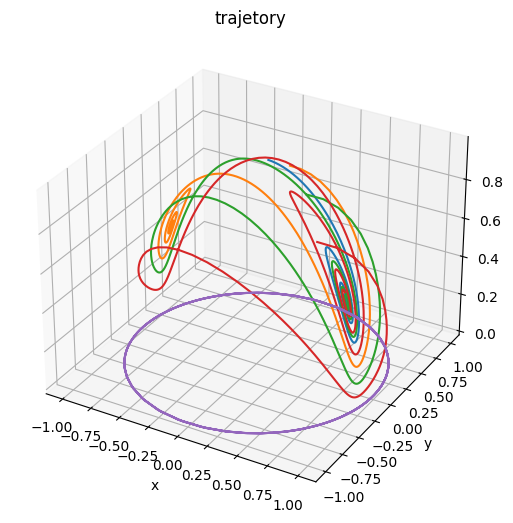

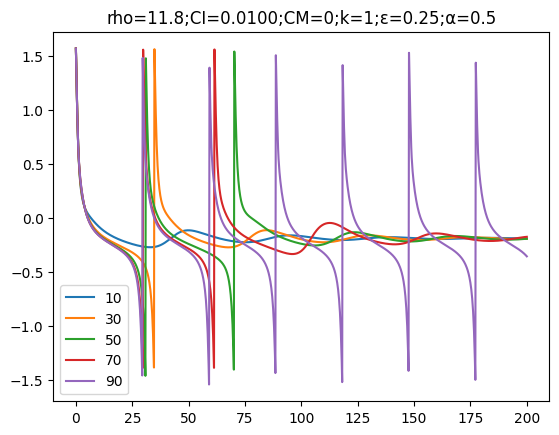

In [4]:
#setting up the axes for 3D plotting
from mpl_toolkits.mplot3d import axes3d,Axes3D
fig = pylab.figure()
ax = fig.add_axes(Axes3D(fig))
ax.set_title("trajetory")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

#psi_clm is the spherical harmonics coefficients object of the ψ, which is implimented by pyshtools package
psi_clm=a1.to_clm(res2['sphharm_co'][-1,:,:])
period_df_1=pd.DataFrame()
thetas=np.array([10,30,50,70,90])/180*np.pi
for theta in thetas:
    phi=90/180*np.pi
    p0=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    df=a1.cal_single_fiber_orbit_confined(p0,psi_clm,200,num=1000,max_step=0.5)
    #plot the trajetory of a single fiber
    ax.plot(df.x,df.y,df.z)
    #store the results in the period_df DataFrame
    period_df_1.loc[:,int(theta/np.pi*180)]=df.loc[:,'phi']
period_df_1.plot(title='rho='+str(a1.rho)+';CI='+'{0:.4f}'.format(a1.CI)+';CM='+str(a1.CM)+';k='+str(a1.k)+\
                 ';ε='+str(confined_epsilon)+';α='+str(confined_alpha))